In [335]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/config_Zendure2400_noBattery.json",
    "out/config_Zendure2400_2880kwh.json",
    "out/config_Zendure2400_5760kwh.json",
    "out/config_Zendure2400_8640kwh.json",
    "out/config_Zendure2400_11520kwh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])

SEASON_ORDER = ["spring", "summer", "autumn", "winter"]

Extract seasonal total_gain_chf (NEW & CLEAN)

In [336]:
rows = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    seasons = data.get("seasons")
    if seasons is None:
        print(f"⚠️ No seasons section in {scenario}, skipping")
        continue

    for season, values in seasons.items():
        flows = values.get("energy_flows", {})
        with_batt = flows.get("with_battery", {})
        without_batt = flows.get("without_battery", {})
        saturation = values.get("battery_saturation", {})
        energy_undersize = values.get("battery_energy_undersize_days", {})
        evening_undersize = values.get("battery_evening_undersize_days", {})
        pu = values.get("power_usage", {})
        charging_at_max = pu.get("charging", {}).get("at_max", {}).get("samples_percent", 0.0)
        discharging_at_max = pu.get("discharging", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_charge_at_max = pu.get("idle", {}).get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_discharge_at_max = pu.get("idle", {}).get("could_discharge", {}).get("at_max", {}).get("samples_percent", 0.0)
        
        idle = pu.get("idle", {})
        could_charge_at_max = (idle.get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0))
        no_opportunity = idle.get("no_opportunity", {}).get("samples_percent", 0.0)

        rows.append({
            "season": season.lower(),
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "total_gain_chf": values.get("total_gain_chf", 0.0),

            "grid_consumed_with_kwh": with_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_with_kwh": with_batt.get("grid_injected_kwh", 0.0),

            "grid_consumed_without_kwh": without_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_without_kwh": without_batt.get("grid_injected_kwh", 0.0),
            
            "battery_charged_kwh": with_batt.get("battery_charged_kwh", 0.0),
            "battery_discharged_kwh": with_batt.get("battery_discharged_kwh", 0.0),   

            "avg_full_pct": saturation.get("average_full_share_percent", 0.0),
            "avg_empty_pct": saturation.get("average_empty_share_percent", 0.0),

            "energy_undersize_pct": energy_undersize.get("percent", 0.0),
            "evening_undersize_pct": evening_undersize.get("percent", 0.0),

            "power_at_max_pct": charging_at_max + discharging_at_max + idle_could_charge_at_max + idle_could_discharge_at_max,

            "charging_at_max_pct": charging_at_max,
            "discharging_at_max_pct": discharging_at_max,
            "idle_could_charge_at_max_pct": idle_could_charge_at_max,
            "idle_could_discharge_at_max_pct": idle_could_discharge_at_max,

            "active_power_at_max_pct": charging_at_max + discharging_at_max,
            "idle_power_limited_pct" : idle_could_discharge_at_max + idle_could_charge_at_max,

            "idle_could_charge_at_max_pct": could_charge_at_max,

            
        })

df_energy = pd.DataFrame(rows)

df_energy["season"] = pd.Categorical(
    df_energy["season"],
    categories=SEASON_ORDER,
    ordered=True
)

df_energy = df_energy.sort_values("battery_size_wh")

scenario_order = (
    df_energy[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)

Plot – Seasonal Total Gain (CHF)

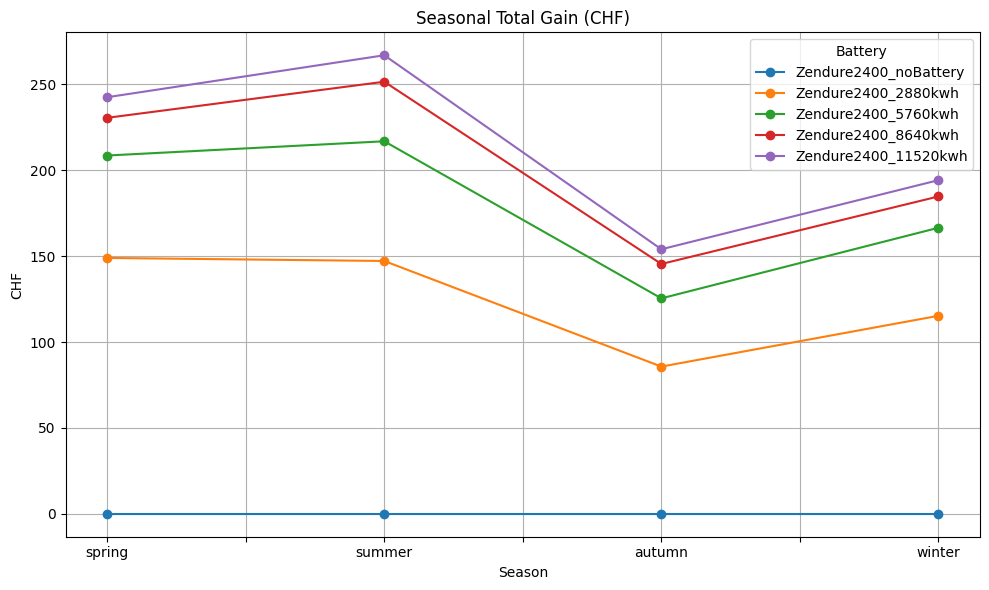

In [337]:

pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="total_gain_chf"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")

plt.title("Seasonal Total Gain (CHF)")
plt.xlabel("Season")
plt.ylabel("CHF")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()



Graph 1 – Seasonal Grid Consumed (with battery)

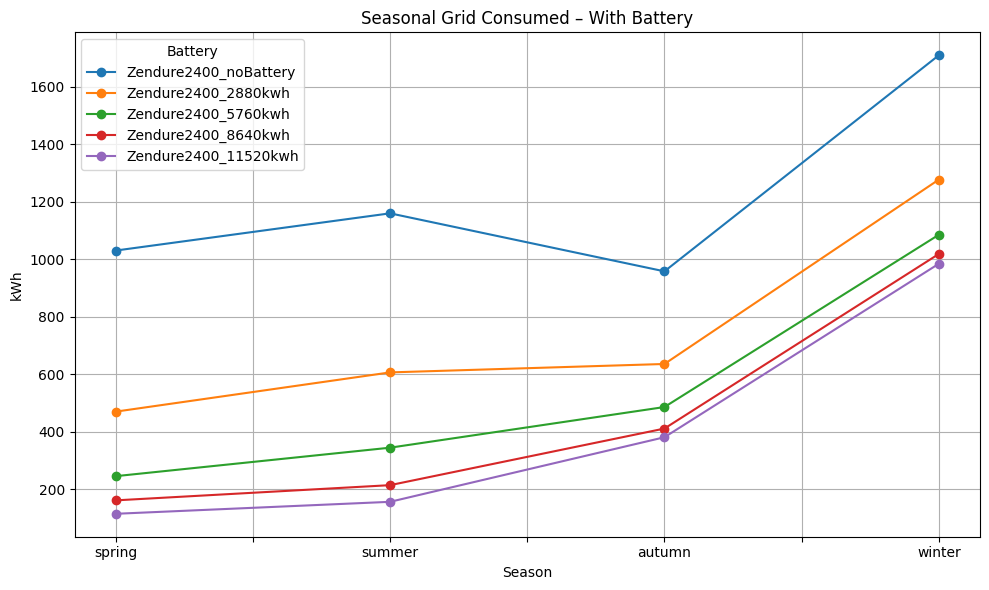

In [338]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="grid_consumed_with_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Grid Consumed – With Battery")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Graph 2 – Seasonal Grid Injected (with battery)

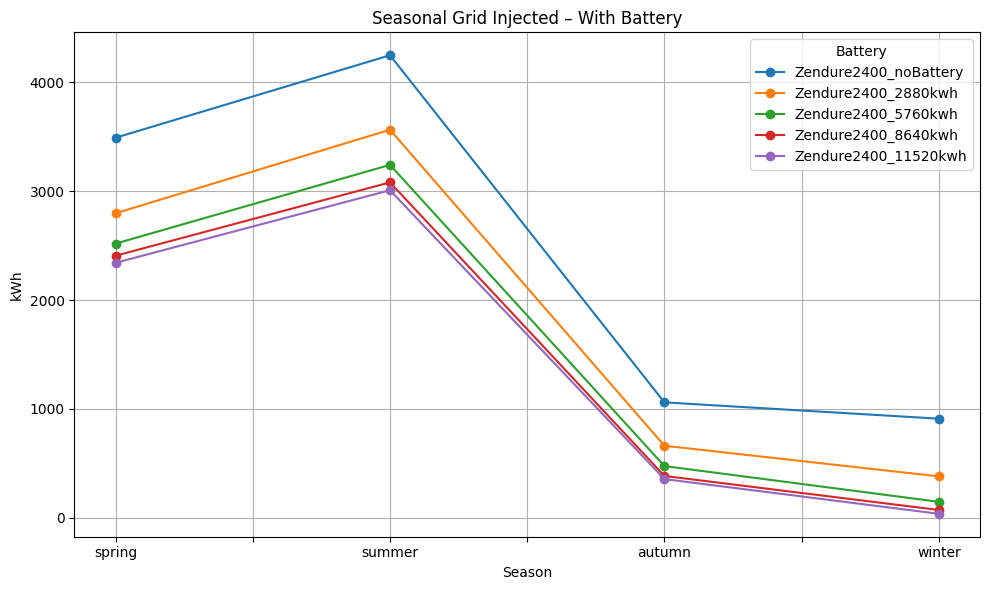

In [339]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="grid_injected_with_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Grid Injected – With Battery")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Graph – Seasonal Battery Charged / Dicharged Energy

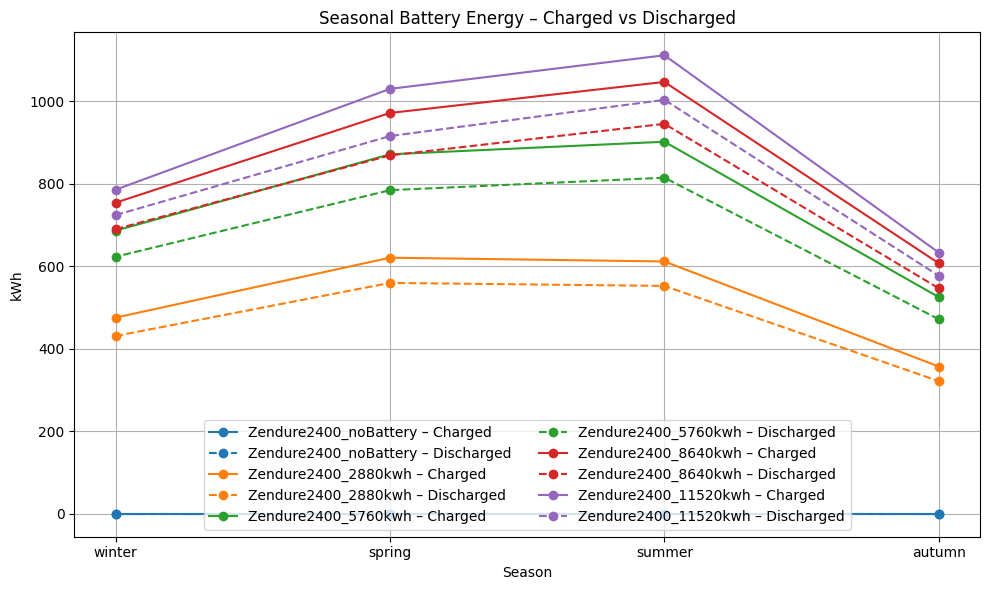

In [340]:
plt.figure(figsize=(10, 6))

# get a stable color cycle (matplotlib default)
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = df_energy[df_energy["scenario"] == scenario]
    color = color_cycle[i % len(color_cycle)]

    # Charged (solid)
    plt.plot(
        subset["season"],
        subset["battery_charged_kwh"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Charged"
    )

    # Discharged (dashed)
    plt.plot(
        subset["season"],
        subset["battery_discharged_kwh"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{scenario} – Discharged"
    )

plt.title("Seasonal Battery Energy – Charged vs Discharged")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()



Seasonal Battery Throughput

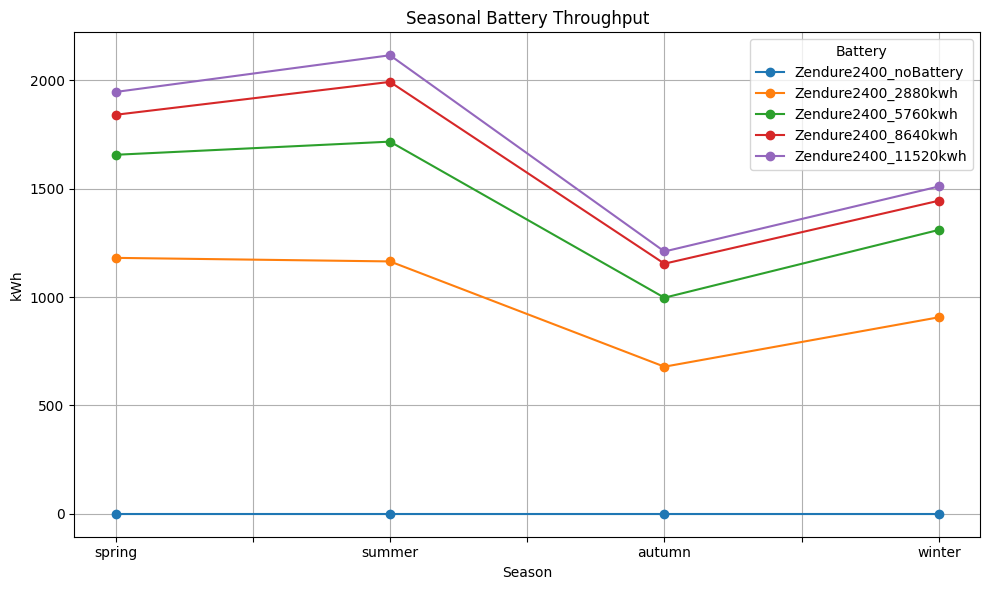

In [341]:
df_energy["battery_throughput_kwh"] = (
    df_energy["battery_charged_kwh"] +
    df_energy["battery_discharged_kwh"]
)

pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="battery_throughput_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Battery Throughput")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Seasonal Battery FULL share

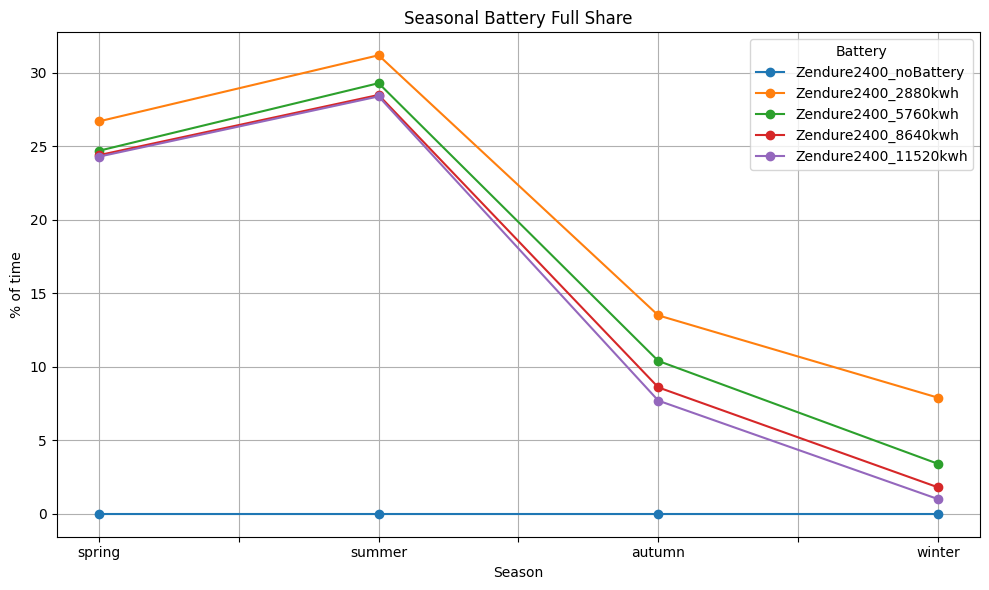

In [342]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="avg_full_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Battery Full Share")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Seasonal Battery EMPTY share

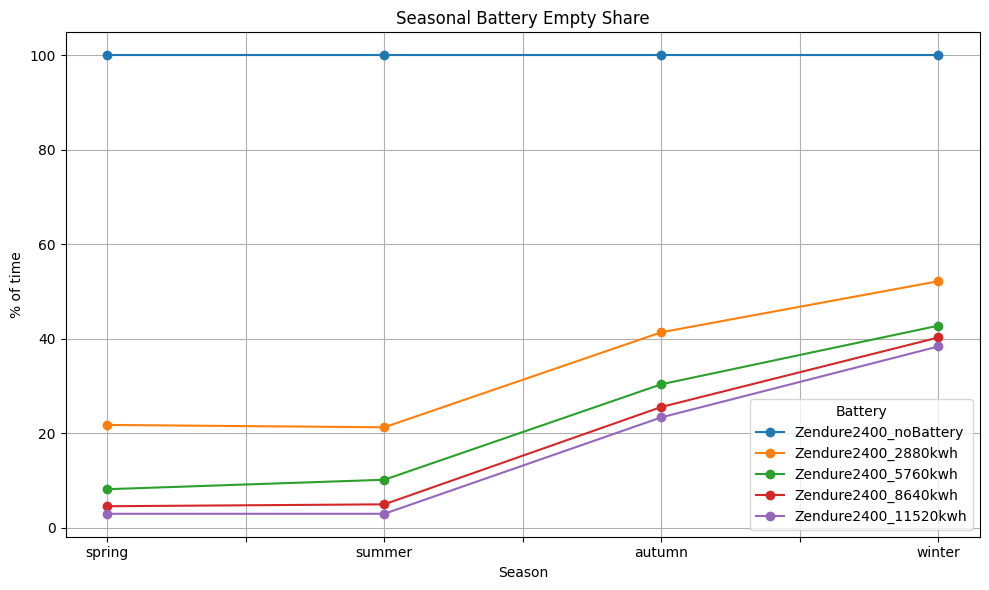

In [343]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="avg_empty_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Battery Empty Share")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Graph – Seasonal Energy Undersize Days

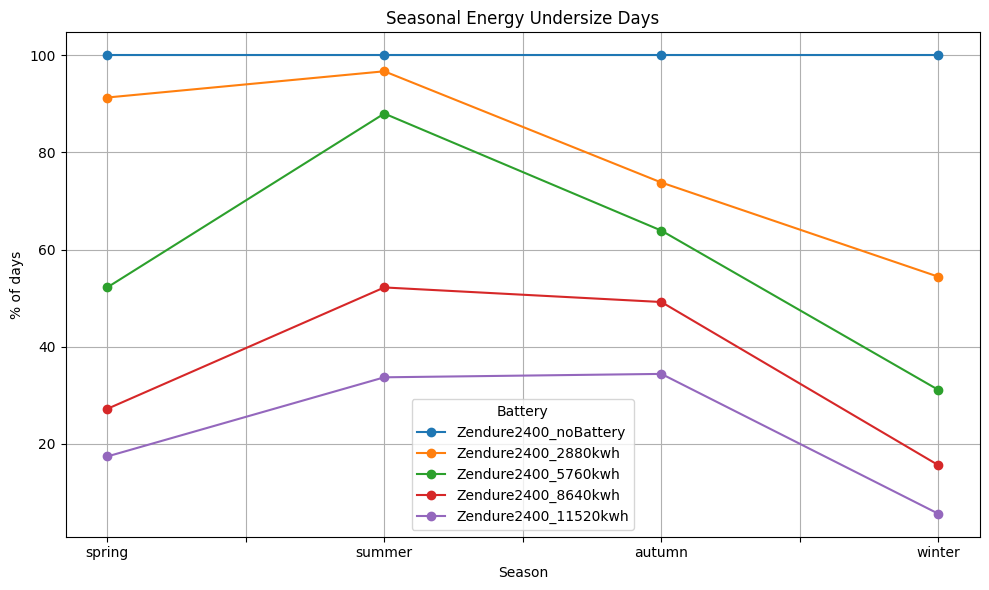

In [344]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="energy_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Energy Undersize Days")
plt.xlabel("Season")
plt.ylabel("% of days")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Graph – Seasonal Evening Undersize Days

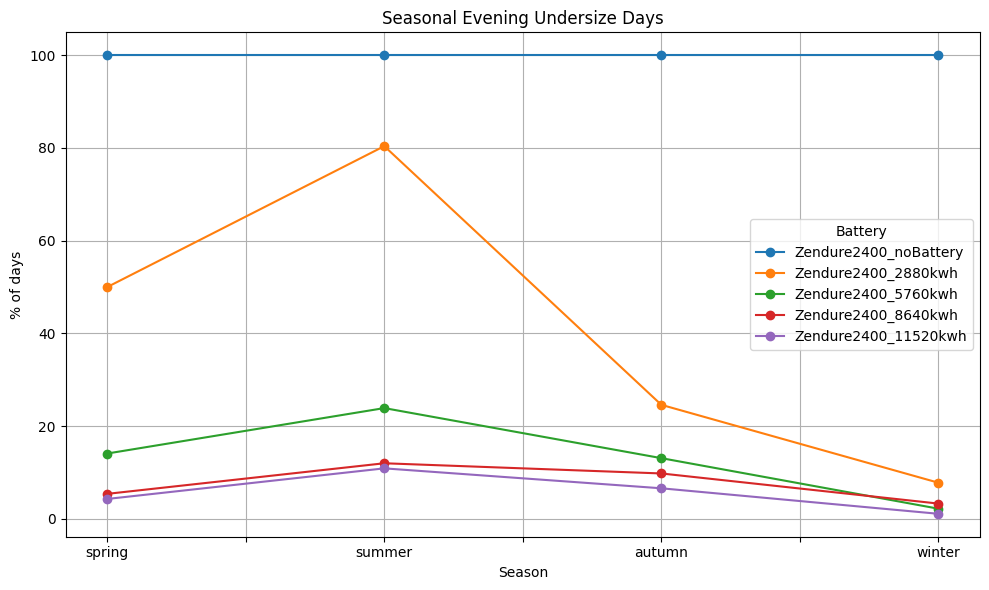

In [345]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="evening_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Evening Undersize Days")
plt.xlabel("Season")
plt.ylabel("% of days")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


Plot – Seasonal Power Saturation

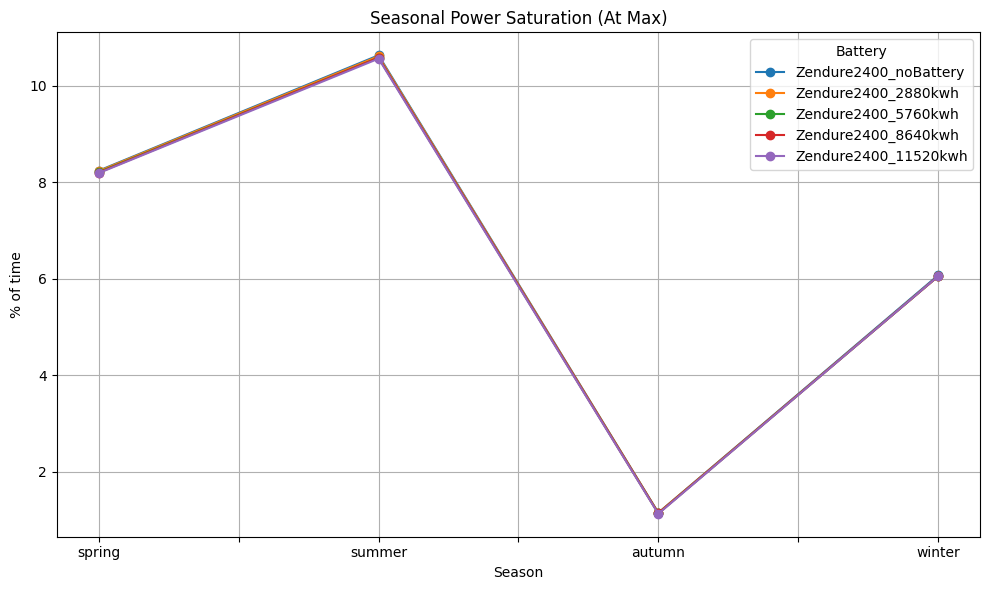

In [346]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="power_at_max_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Power Saturation (At Max)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


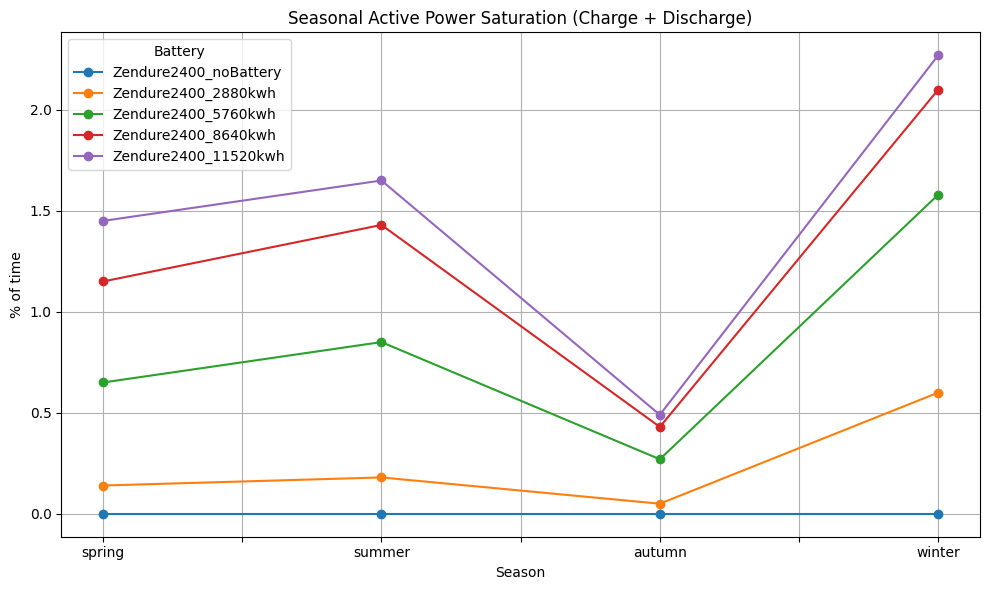

In [347]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="active_power_at_max_pct"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Active Power Saturation (Charge + Discharge)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


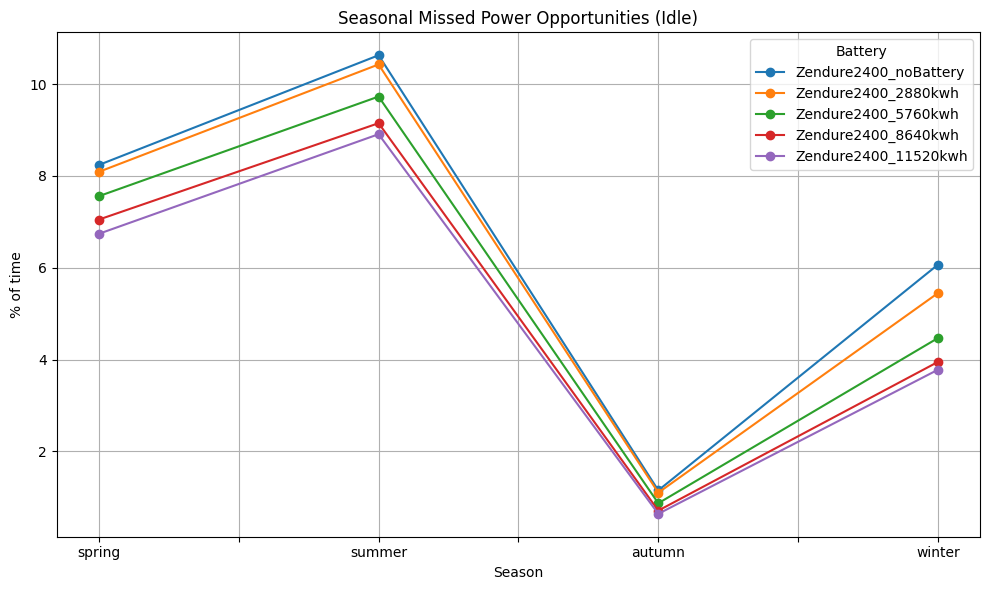

In [348]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="idle_power_limited_pct"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Missed Power Opportunities (Idle)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()
